# Placing Bats Randomly in an Image

## Create Image with n by n buffer

In [211]:
import numpy as np

In [212]:
import matplotlib.pyplot as plt


def quickshow(img):
    plt.imshow(img, cmap= 'gray', vmin=0, vmax=255)
    plt.axis('off')  # Turn off axis
    plt.show()

## Randomly Place Points and Calculate Euclidian Distance

In [213]:
import numpy as np

In [319]:
import random 

def random_point(n)->tuple:
    return np.random.randint(0, n + 1), np.random.randint(0, n + 1)

def too_close(point: tuple, lst: list, thresh: float)->bool:
    """
    Returns True if distance is under thresh, False if it's further
    """
    for other in lst:
        distance = np.linalg.norm(np.array(point) - np.array(other))
        if distance <= thresh:
            return True
    return False

def bat_coords(n, thresh, img_size=40):
    points_list = []
    # for _ in range(0, n):
    if thresh < 3:
        scaling_value = 0.5 
    elif thresh < 7:
        scaling_value = 0.3
    else:
        scaling_value = 0.2

    width = img_size * scaling_value
    while True:
        for _ in range(50):
            p1 = None
            smallest_point = 30
            p1 = random_point(smallest_point)
            if too_close(p1, points_list, width):
                points_list.clear()
            points_list.append(p1)
            if len(points_list)==n:
                return points_list

In [215]:
point, other = bat_coords(2, 20, 2)
np.linalg.norm(np.array(point) - np.array(other))

21.93171219946131

## Rotate an Image

In [216]:
import os
import random
import cv2

### Load random Image

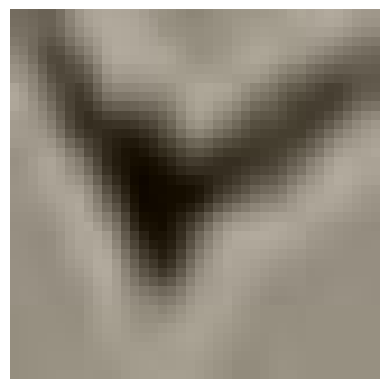

In [217]:

def load_random(directory):
    files = os.listdir(directory)
    image_path = random.choice(files)
    image_path = os.path.join(directory, image_path)
    image = cv2.imread(image_path)
    # if image.shape[2] > 1:
    #     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image
test_img = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\1')
quickshow(test_img)

### Segment The Image

In [218]:
def mask_with_Kmeans(image, reverse=False):
    """
    If the bat is darker than the background 
    """
    if reverse:
        image = 255-image
    pixel_values = image.reshape((-1, image.shape[-1]))
    k = 2
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(np.float32(pixel_values), k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    binary_mask = np.uint8(labels.reshape(image.shape[:2]))

    # Make masking consistant! Takes the mean of the estimated object and background and if the "object" is lighter color swap the two.
    # This assumes that the bats will always be darker than the background, if this is not true
    # invert the image before it is given to this function.
    if cv2.mean(image, mask=binary_mask) > cv2.mean(image, mask=~binary_mask):
        binary_mask = ~binary_mask
    max_val = binary_mask.max()
    min_val = binary_mask.min()
    binary_mask[binary_mask==max_val]=255
    binary_mask[binary_mask==min_val]=0

    return binary_mask

**Testing the Functions:**
* `load_random()`
* `mask_with_Kmeans()`

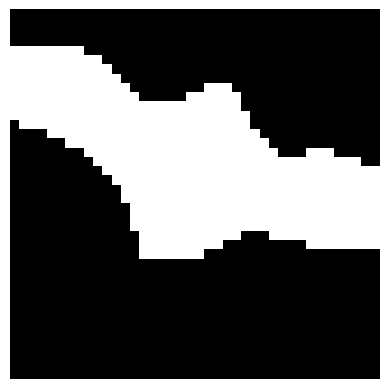

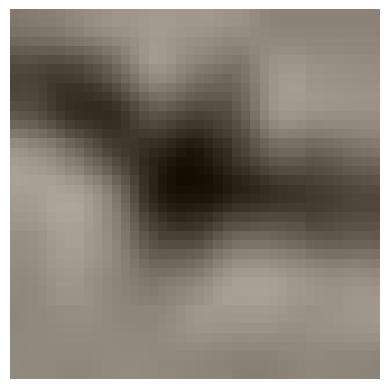

In [219]:
image = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\1')
# print(image)
image_mask = mask_with_Kmeans(image)
# quickshow(~image_mask)
quickshow(image_mask)

quickshow(image)

## Rotate an Image

In [220]:
from PIL import Image
import random

def rotate_img(img, theta=45):
    PIL_img = Image.fromarray(img)
    theta_1 = random.uniform(-theta, theta)
    rotated_image = PIL_img.rotate(theta_1)
    return np.asarray(rotated_image)



255 0


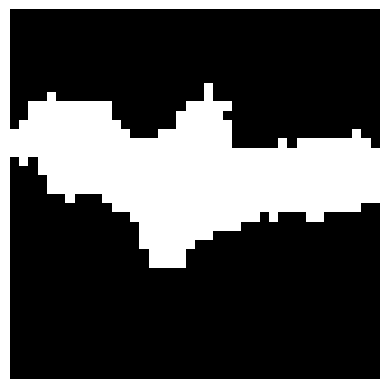

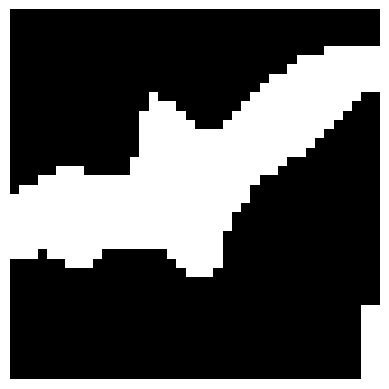

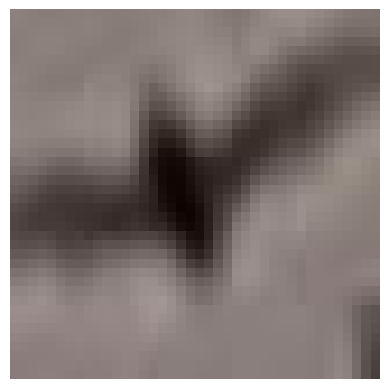

In [221]:
img_test = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\1')
masked_img = mask_with_Kmeans(img_test)
print(masked_img.max(), masked_img.min())
rotated_img = rotate_img(masked_img)

quickshow(rotated_img)
quickshow(masked_img)
quickshow(img_test)

## Placing Images on Background

### Placing images on new Background

In [222]:
from PIL import Image, ImageFilter, ImageEnhance
def add_noise(image, factor):
    enhancer = ImageEnhance.Color(image)
    noisy_image = enhancer.enhance(factor)
    return noisy_image

def add_blur(image, radius):
    blurred_image = image.filter(ImageFilter.GaussianBlur(radius))
    return blurred_image

[(17, 7), (29, 3), (20, 19), (4, 21), (30, 27), (0, 9)]
(40, 40, 3)


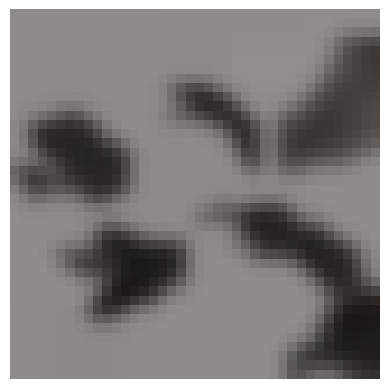

In [324]:
def place_image(img, mask, bkg, coords):
    x, y = coords
    image = Image.fromarray(img)
    masked = Image.fromarray(mask)
    background = Image.fromarray(bkg)
    background.paste(image, (x, y), mask=masked)
    return np.asarray(background)


def shrink_image(img, k):
    image = Image.fromarray(img)
    width, height = image.size
    if k < 3:
        new_width = random.uniform(0.5, 0.8)
    elif k < 8:
        new_width = random.uniform(0.3, 0.5)
    else:
        new_width = random.uniform(0.3, 0.4)


    w = int(width*new_width)
    return np.asarray(image.resize((w, w)))
number_of_bats = 6


background = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\0')
coords = bat_coords(number_of_bats, number_of_bats)
print(coords)
for i in range(number_of_bats):
    image = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (319530501)\1')
    image = shrink_image(image, number_of_bats)
    masked_img = mask_with_Kmeans(image)
    background = place_image(image, masked_img, background, coords[i])

bkg = Image.fromarray(background)
bkg = add_noise(bkg, 0.3)
bkg = add_blur(bkg, 1)

bkg = np.asarray(bkg)
print(bkg.shape)
quickshow(bkg)

# Final Output Creation

In [321]:
output_folder = 'Aug Data' # Folder and it's subdirectories must be made prior to running this chunk (cause I'm lazy)

for number_of_bats in [5, 6, 7, 8]:
    for i in range(0, 2000):
        print(f"Round {i}")
        scale = 2
        for target in [ '319530501', '412546891', 'emergence','Lumix']:
            background = load_random(r'Bats\Bats\Cropped Count Images\NewCroppedImages (emergence)\0')
            coords = bat_coords(number_of_bats, number_of_bats)
            for x, y in coords:
                image = load_random(fr'Bats\Bats\Cropped Count Images\NewCroppedImages ({target})\1')
                image = shrink_image(image, number_of_bats)
                masked_img = mask_with_Kmeans(image)
                background = place_image(image, masked_img, background, (x,y))
                
            img_to_save = Image.fromarray(background)
            img_to_save = add_noise(img_to_save, 0.3)
            img_to_save = add_blur(img_to_save, 1)
            img_to_save.save(fr'{output_folder}\{number_of_bats}\{target}_{i}.jpg')

Round 0
Round 1
Round 2
Round 3
Round 4
Round 5
Round 6
Round 7
Round 8
Round 9
Round 10
Round 11
Round 12
Round 13
Round 14
Round 15
Round 16
Round 17
Round 18
Round 19
Round 20
Round 21
Round 22
Round 23
Round 24
Round 25
Round 26
Round 27
Round 28
Round 29
Round 30
Round 31
Round 32
Round 33
Round 34
Round 35
Round 36
Round 37
Round 38
Round 39
Round 40
Round 41
Round 42
Round 43
Round 44
Round 45
Round 46
Round 47
Round 48
Round 49
Round 50
Round 51
Round 52
Round 53
Round 54
Round 55
Round 56
Round 57
Round 58
Round 59
Round 60
Round 61
Round 62
Round 63
Round 64
Round 65
Round 66
Round 67
Round 68
Round 69
Round 70
Round 71
Round 72
Round 73
Round 74
Round 75
Round 76
Round 77
Round 78
Round 79
Round 80
Round 81
Round 82
Round 83
Round 84
Round 85
Round 86
Round 87
Round 88
Round 89
Round 90
Round 91
Round 92
Round 93
Round 94
Round 95
Round 96
Round 97
Round 98
Round 99
Round 100
Round 101
Round 102
Round 103
Round 104
Round 105
Round 106
Round 107
Round 108
Round 109
Round 110


In [18]:
len(os.listdir(r"Testing\4"))

8000